# Experimentos y Diseño de Experimentos

@Laboratorio de Causalidad

2024-09-26

## Librerías y funciones

In [34]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.stats.power import FTestAnovaPower

import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
def eval_pvalue(obs_p_value, limite = 0.05):
    # Conclusión sobre el efecto de la dosis
    if obs_p_value < limite:
        print(f"\nConclusión: Existe una diferencia significativa en la reducción del tamaño del tumor segun el factor. (p-valor = {p_value:.4f}).")
    else:
        print("\nConclusión: No existe una diferencia significativa en la reducción del tamaño del tumor.")

In [36]:
def fit_plots(df):
    # Crear figura con subplots 2x2
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    
    # Gráfico Q-Q para verificar la normalidad de los residuos
    sm.qqplot(df['residuales'], line ='45', fit=True, ax=axs[0, 0])
    axs[0, 0].set_title("Gráfico Q-Q de los Residuos")
    axs[0, 0].set_ylabel('Cuantiles Muestrales')
    axs[0, 0].set_xlabel('Cuantiles Teóricos')
    
    # Gráfico de residuos vs. valores predichos para verificar homocedasticidad
    sns.scatterplot(x='prediccion', y='residuales', data=df, ax=axs[0, 1])
    axs[0, 1].axhline(0, color='blue', linestyle='--')
    axs[0, 1].set_title("Residuos vs. Valores Predichos")
    axs[0, 1].set_xlabel('Valores Predichos')
    axs[0, 1].set_ylabel('Residuos')
    
    # Gráfico de residuos vs. nivel de dosis para verificar independencia
    sns.stripplot(x='Dosis', y='residuales', data=df, jitter=True, ax=axs[1, 0])
    axs[1, 0].axhline(0, color='blue', linestyle='--')
    axs[1, 0].set_title("Residuos vs. Nivel de Dosis")
    axs[1, 0].set_xlabel('Nivel de Dosis')
    axs[1, 0].set_ylabel('Residuos')
    
    # Gráfico de valores observados vs. predicciones del modelo
    sns.scatterplot(x='prediccion', y='Reducción', data=df, ax=axs[1, 1])
    axs[1, 1].plot([df['prediccion'].min(), df['prediccion'].max()], 
                   [df['prediccion'].min(), df['prediccion'].max()], 
                   color='red', linestyle='--')
    axs[1, 1].set_title("Valores Observados vs. Valores Predichos")
    axs[1, 1].set_xlabel('Valores Predichos')
    axs[1, 1].set_ylabel('Valores Observados')
    
    # Ajustar el diseño de los subplots
    plt.tight_layout()
    plt.show()
    

## Diseño Aleatorizado

In [4]:
# Simulación de datos para el experimento aleatorizado
np.random.seed(42)

# Definimos los niveles del factor
doses = ['Bajo', 'Alto']
replicas = 3  # Número de pacientes (réplicas) por nivel de dosis

#### Data

In [5]:
# Generando datos simulados de reducción de tumores en porcentaje
data = {
    'Dosis': np.repeat(doses, replicas),
    'Reducción': np.concatenate([
        np.random.normal(20, 10, replicas),  # Dosis baja
        np.random.normal(40, 10, replicas)   # Dosis alta
    ])
}

# Creación del DataFrame
df = pd.DataFrame(data)

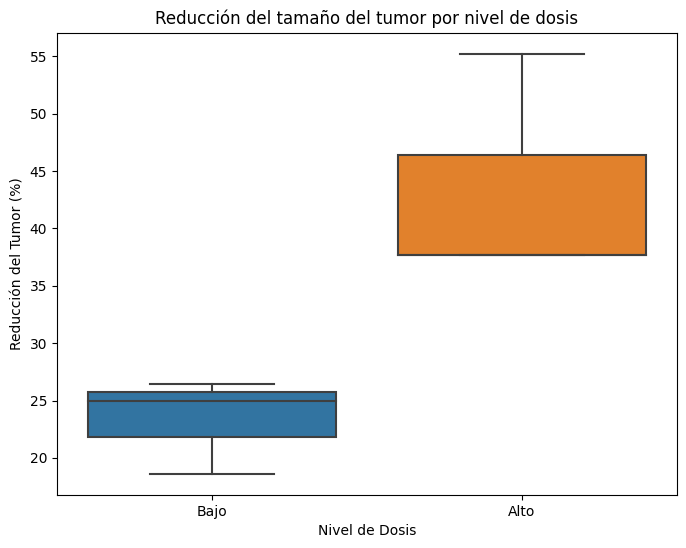

In [6]:
# Visualización de los datos
plt.figure(figsize=(8, 6))
sns.boxplot(x='Dosis', y='Reducción', data=df)
plt.title('Reducción del tamaño del tumor por nivel de dosis')
plt.xlabel('Nivel de Dosis')
plt.ylabel('Reducción del Tumor (%)')
plt.show()

#### Potencia

In [7]:
# Definir los parámetros del experimento
effect_size = 0.8  # Tamaño del efecto, puedes ajustarlo según el escenario (típicamente 0.2, 0.5, 0.8 para pequeño, medio, grande)
alpha = 0.05  # Nivel de significancia
groups = len(doses)  # Número de grupos (Dosis alta y baja)

# Crear un objeto FTestAnovaPower
anova_power = FTestAnovaPower()

In [8]:
# Calcular la potencia
nobs = df.shape[0]  # Número total de observaciones
power = anova_power.solve_power(effect_size=effect_size, nobs=nobs, alpha=alpha, k_groups=groups)
print(f"Potencia del experimento de un factor (Nivel de Dosis) con {nobs}: {power:.4f}")

Potencia del experimento de un factor (Nivel de Dosis) con 6: 0.3251


In [9]:
# Definir los parámetros
power = 0.8  # Potencia deseada (80%)

# Calcular el tamaño de muestra necesario
sample_size = anova_power.solve_power(effect_size=effect_size, alpha=alpha, power=power, k_groups=groups)
print(f"Tamaño de muestra necesario para un diseño de un factor: {int(np.ceil(sample_size))} observaciones")

Tamaño de muestra necesario para un diseño de un factor: 15 observaciones


#### Modelo

In [10]:
# ANOVA de un factor para nivel de dosis
model = ols('Reducción ~ C(Dosis)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Dosis),609.759595,1.0,10.135855,0.033417
Residual,240.634696,4.0,NaN,NaN


In [11]:
p_value = anova_table['PR(>F)'][0]
eval_pvalue(p_value)


Conclusión: Existe una diferencia significativa en la reducción del tamaño del tumor segun el factor. (p-valor = 0.0334).


#### Ajuste

In [12]:
# Añadir residuos y predicciones al DataFrame
df['residuales'] = model.resid
df['prediccion'] = model.fittedvalues

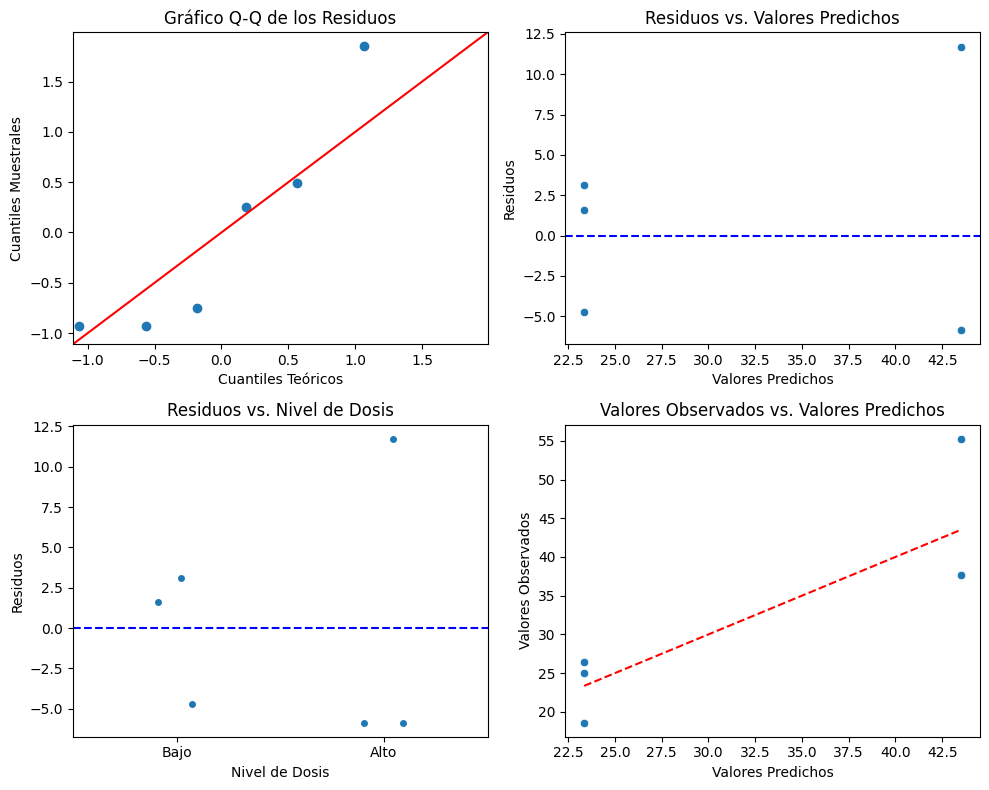

In [13]:
fit_plots(df)

## Diseño en Bloques Completos

In [14]:
# Simulación de datos para el experimento con bloques completos aleatorizados
np.random.seed(42)

# Definimos los factores y bloques
doses = ['Bajo', 'Alto']
cancer_phases = ['Fase T', 'Fase N', 'Fase M2']
replicas = 5  # Número de pacientes (réplicas) por combinación de fase y dosis

#### Data

In [15]:
# Generando datos simulados de reducción de tumores en porcentaje
data = {
    'Dosis': np.tile(doses, len(cancer_phases) * replicas),
    'Fase': np.repeat(cancer_phases, len(doses) * replicas),
    'Reducción': np.concatenate([
        np.random.normal(25, 5, replicas),  # Fase T con Dosis baja
        np.random.normal(35, 5, replicas),  # Fase T con Dosis alta
        np.random.normal(20, 5, replicas),  # Fase N con Dosis baja
        np.random.normal(30, 5, replicas),  # Fase N con Dosis alta
        np.random.normal(15, 5, replicas),  # Fase M2 con Dosis baja
        np.random.normal(25, 5, replicas)   # Fase M2 con Dosis alta
    ])
}

# Creación del DataFrame
df = pd.DataFrame(data)

In [37]:
# Visualización de los datos
plt.figure(figsize=(10, 6))
sns.boxplot(x='Dosis', y='Reducción', hue='Fase', data=df)
plt.title('Reducción del tamaño del tumor por nivel de dosis y fase del cáncer')
plt.xlabel('Nivel de Dosis')
plt.ylabel('Reducción del Tumor (%)')
plt.show()

ValueError: Could not interpret input 'Fase'

<Figure size 1000x600 with 0 Axes>

#### Potencia

In [17]:
# Definir los parámetros del experimento
effect_size = 0.8  # Tamaño del efecto, puedes ajustarlo según el escenario (típicamente 0.2, 0.5, 0.8 para pequeño, medio, grande)
alpha = 0.05  # Nivel de significancia
groups = len(doses) * len(cancer_phases)  # Número de grupos (2 niveles de dosis x 3 bloques)

# Crear un objeto FTestAnovaPower
anova_power = FTestAnovaPower()

In [18]:
# Calcular la potencia
nobs = df.shape[0]  # Número total de observaciones
power = anova_power.solve_power(effect_size=effect_size, nobs=nobs, alpha=alpha, k_groups=groups)
print(f"Potencia del experimento de un factor (Nivel de Dosis) con {nobs}: {power:.4f}")

Potencia del experimento de un factor (Nivel de Dosis) con 30: 0.8741


In [19]:
# Definir los parámetros
power = 0.8  # Potencia deseada (80%)

# Calcular el tamaño de muestra necesario
sample_size = anova_power.solve_power(effect_size=effect_size, alpha=alpha, power=power, k_groups=groups)
print(f"Tamaño de muestra necesario para un diseño de bloques: {int(np.ceil(sample_size))} observaciones")

Tamaño de muestra necesario para un diseño de bloques: 27 observaciones


#### Modelo

In [20]:
# ANOVA con diseño de bloques completos aleatorizados
model = ols('Reducción ~ C(Dosis) + C(Fase)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Dosis),25.907495,1.0,0.608976,0.442221
C(Fase),1027.181340,2.0,12.072344,0.000196
Residual,1106.111409,26.0,NaN,NaN


In [21]:
# Análisis de resultados
dosis_p_value = anova_table['PR(>F)']['C(Dosis)']
fase_p_value = anova_table['PR(>F)']['C(Fase)']
eval_pvalue(dosis_p_value)


Conclusión: No existe una diferencia significativa en la reducción del tamaño del tumor.


#### Ajuste

In [22]:
# Añadir residuos y predicciones al DataFrame
df['residuales'] = model.resid
df['prediccion'] = model.fittedvalues

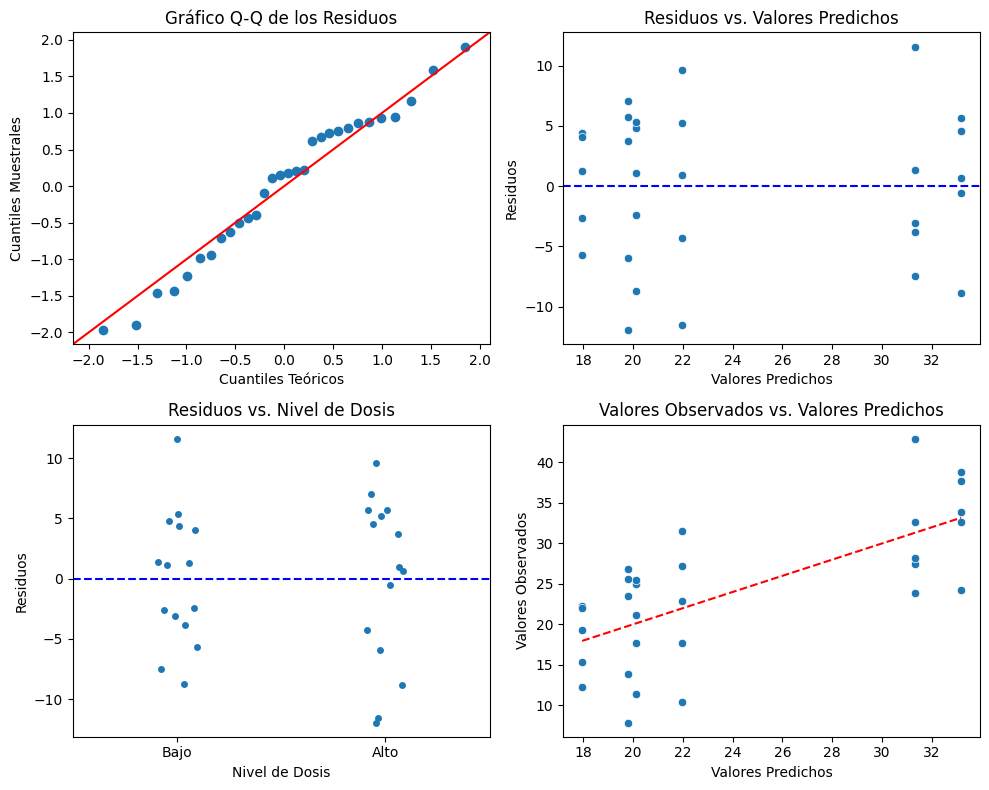

In [23]:
fit_plots(df)


## Diseño 2 Factores

In [24]:
# Simulación de datos para el experimento
np.random.seed(42)

# Factores
doses = ['Bajo', 'Alto']
ages = ['Niñez', 'Adultez']
replicas = 10  # Número de réplicas por cada combinación de dosis y edad

#### Data

In [25]:
# Generando datos simulados de reducción de tumores en porcentaje
data = {
    'Dosis': np.repeat(doses, len(ages) * replicas),
    'Edad': np.tile(np.repeat(ages, replicas), len(doses)),
    'Reducción': np.concatenate([
        np.random.normal(20, 5, replicas),  # Dosis baja, Niñez
        np.random.normal(30, 5, replicas),  # Dosis baja, Adultez
        np.random.normal(50, 5, replicas),  # Dosis alta, Niñez
        np.random.normal(40, 5, replicas)   # Dosis alta, Adultez
    ])
}

# Creación del DataFrame
df = pd.DataFrame(data)

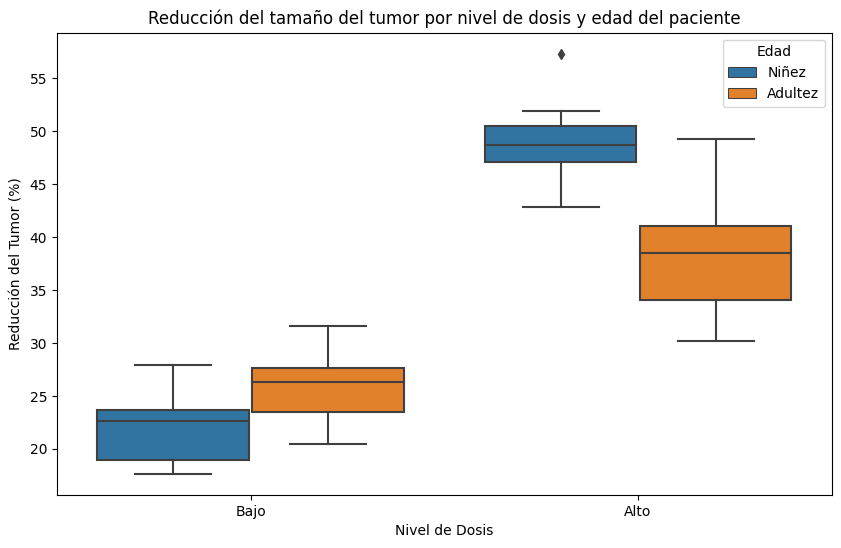

In [26]:
# Visualización de los datos
plt.figure(figsize=(10, 6))
sns.boxplot(x='Dosis', y='Reducción', hue='Edad', data=df)
plt.title('Reducción del tamaño del tumor por nivel de dosis y edad del paciente')
plt.xlabel('Nivel de Dosis')
plt.ylabel('Reducción del Tumor (%)')
plt.show()

#### Potencia

In [27]:
# Definir los parámetros del experimento
effect_size = 0.8  # Tamaño del efecto, puedes ajustarlo según el escenario (típicamente 0.2, 0.5, 0.8 para pequeño, medio, grande)
alpha = 0.05  # Nivel de significancia
groups = len(doses) * len(ages)  # Número de grupos (2 niveles de dosis x 2 edades)

# Crear un objeto FTestAnovaPower
anova_power = FTestAnovaPower()

In [28]:
# Calcular la potencia
nobs = df.shape[0]  # Número total de observaciones
power = anova_power.solve_power(effect_size=effect_size, nobs=nobs, alpha=alpha, k_groups=groups)
print(f"Potencia del experimento de un factor (Nivel de Dosis) con {nobs}: {power:.4f}")

Potencia del experimento de un factor (Nivel de Dosis) con 40: 0.9882


In [29]:
# Definir los parámetros
power = 0.8  # Potencia deseada (80%)

# Calcular el tamaño de muestra necesario
sample_size = anova_power.solve_power(effect_size=effect_size, alpha=alpha, power=power, k_groups=groups)
print(f"Tamaño de muestra necesario para un diseño de 2 factores: {int(np.ceil(sample_size))} observaciones")

Tamaño de muestra necesario para un diseño de 2 factores: 22 observaciones


#### Análisis

In [30]:
# ANOVA de dos factores con interacción
model = ols('Reducción ~ C(Dosis) * C(Edad)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Dosis),3812.887805,1.0,198.895539,3.108504e-16
C(Edad),110.055151,1.0,5.740919,2.189490e-02
C(Dosis):C(Edad),507.493726,1.0,26.472911,9.633998e-06
Residual,690.130919,36.0,NaN,NaN


In [31]:
# Análisis de resultados
dosis_p_value = anova_table['PR(>F)']['C(Dosis)']
edad_p_value = anova_table['PR(>F)']['C(Edad)']
interaccion_p_value = anova_table['PR(>F)']['C(Dosis):C(Edad)']

eval_pvalue(dosis_p_value)
eval_pvalue(edad_p_value)
eval_pvalue(interaccion_p_value)


Conclusión: Existe una diferencia significativa en la reducción del tamaño del tumor segun el factor. (p-valor = 0.0334).

Conclusión: Existe una diferencia significativa en la reducción del tamaño del tumor segun el factor. (p-valor = 0.0334).

Conclusión: Existe una diferencia significativa en la reducción del tamaño del tumor segun el factor. (p-valor = 0.0334).


#### Ajuste

In [32]:
# Añadir residuos y predicciones al DataFrame
df['residuales'] = model.resid
df['prediccion'] = model.fittedvalues

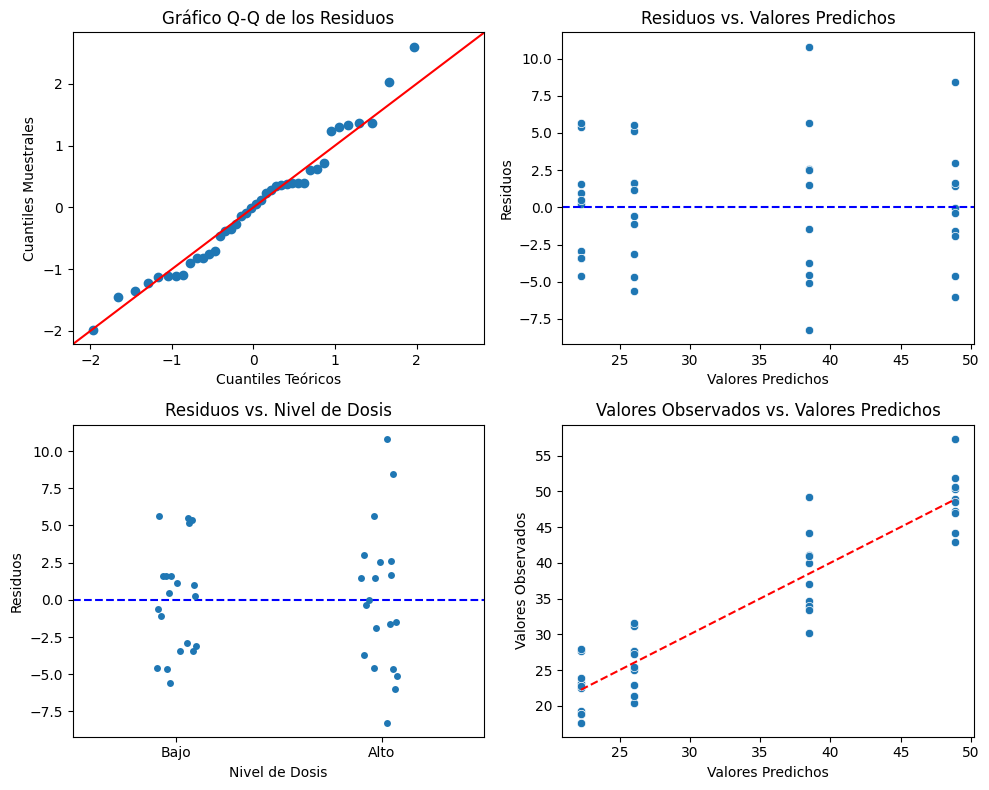

In [33]:
fit_plots(df)